In [35]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Problem 1

## 1) Download the data

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

## 2) Find and describe how the background changes

In [4]:
df = pd.DataFrame(data).transpose()
df.columns = ["gps_time", "solar_phase", "longitude", "count"]

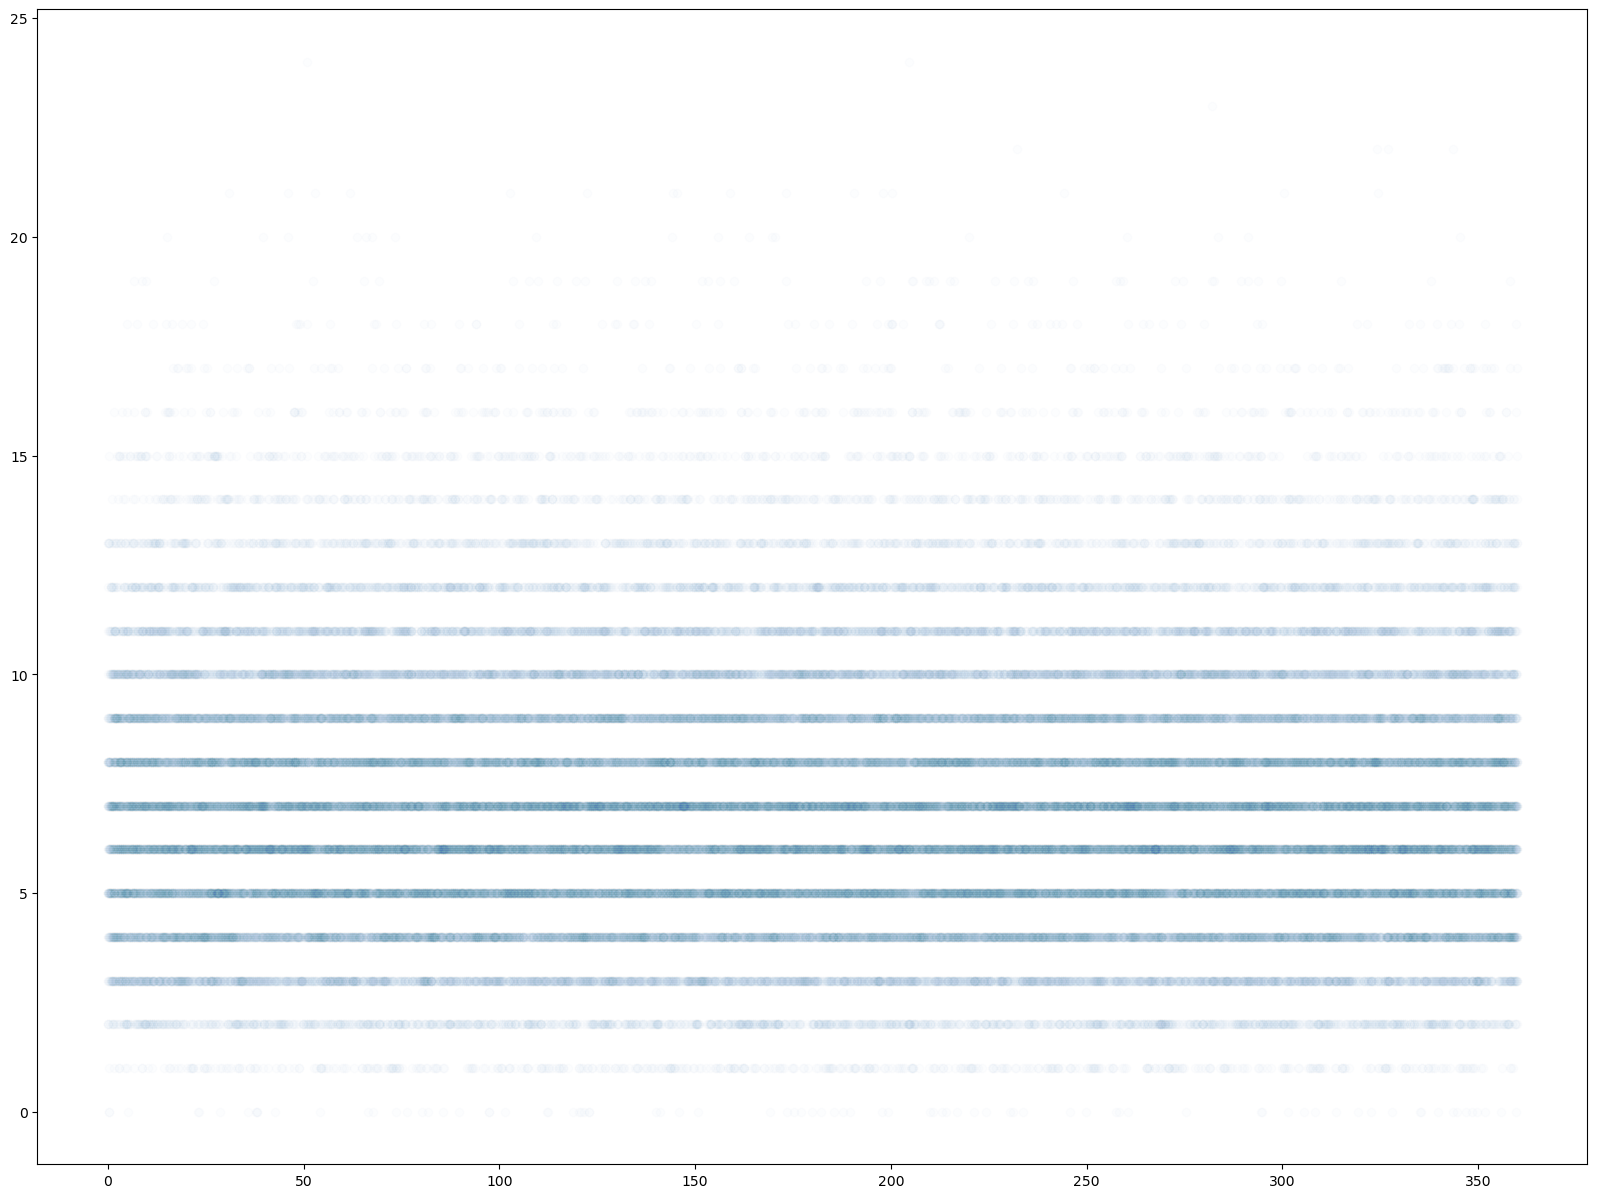

In [5]:
plt.scatter(df['solar_phase'][::500], df['count'][::500], alpha=0.01)
plt.show()

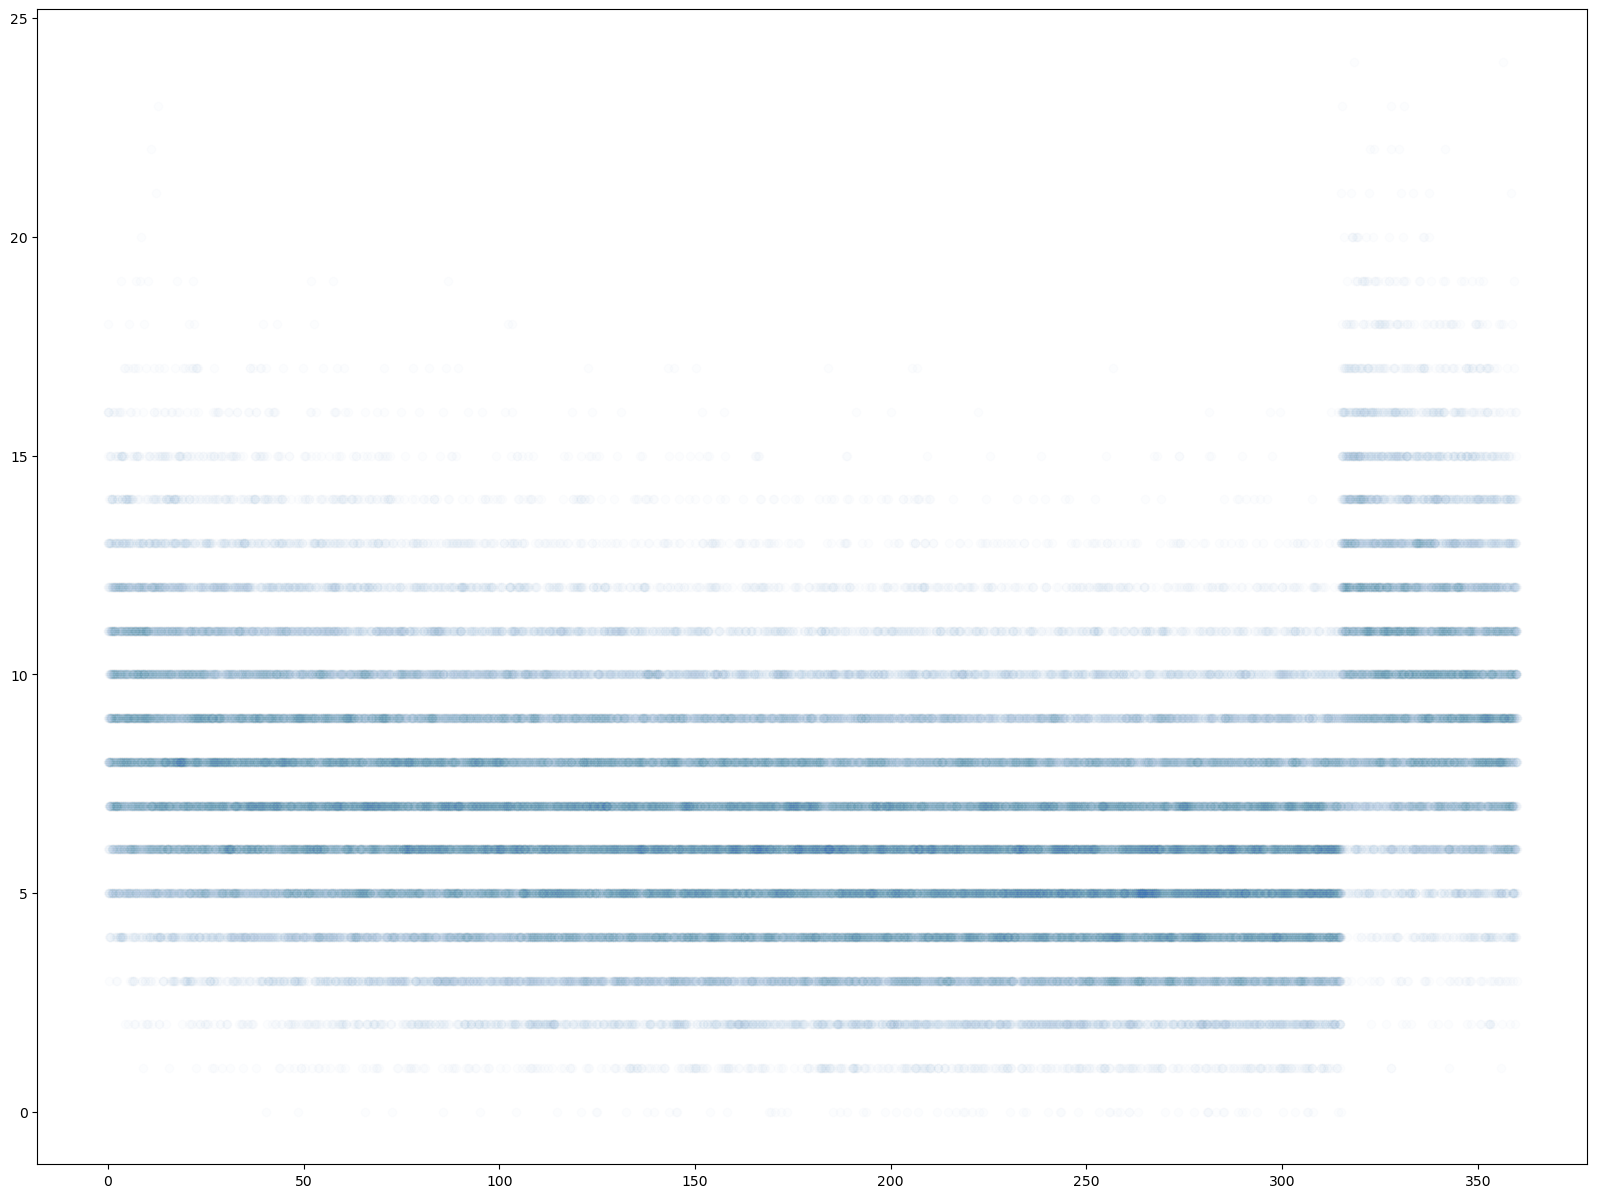

In [6]:
plt.scatter(df['longitude'][::502], df['count'][::502], alpha=0.01)
plt.show()

In [73]:
counts = [0]*3600
for i in range(len(df["count"][::54])):
    counts[math.floor(df["longitude"][i*54]*10)] += int(df["count"][i*54])

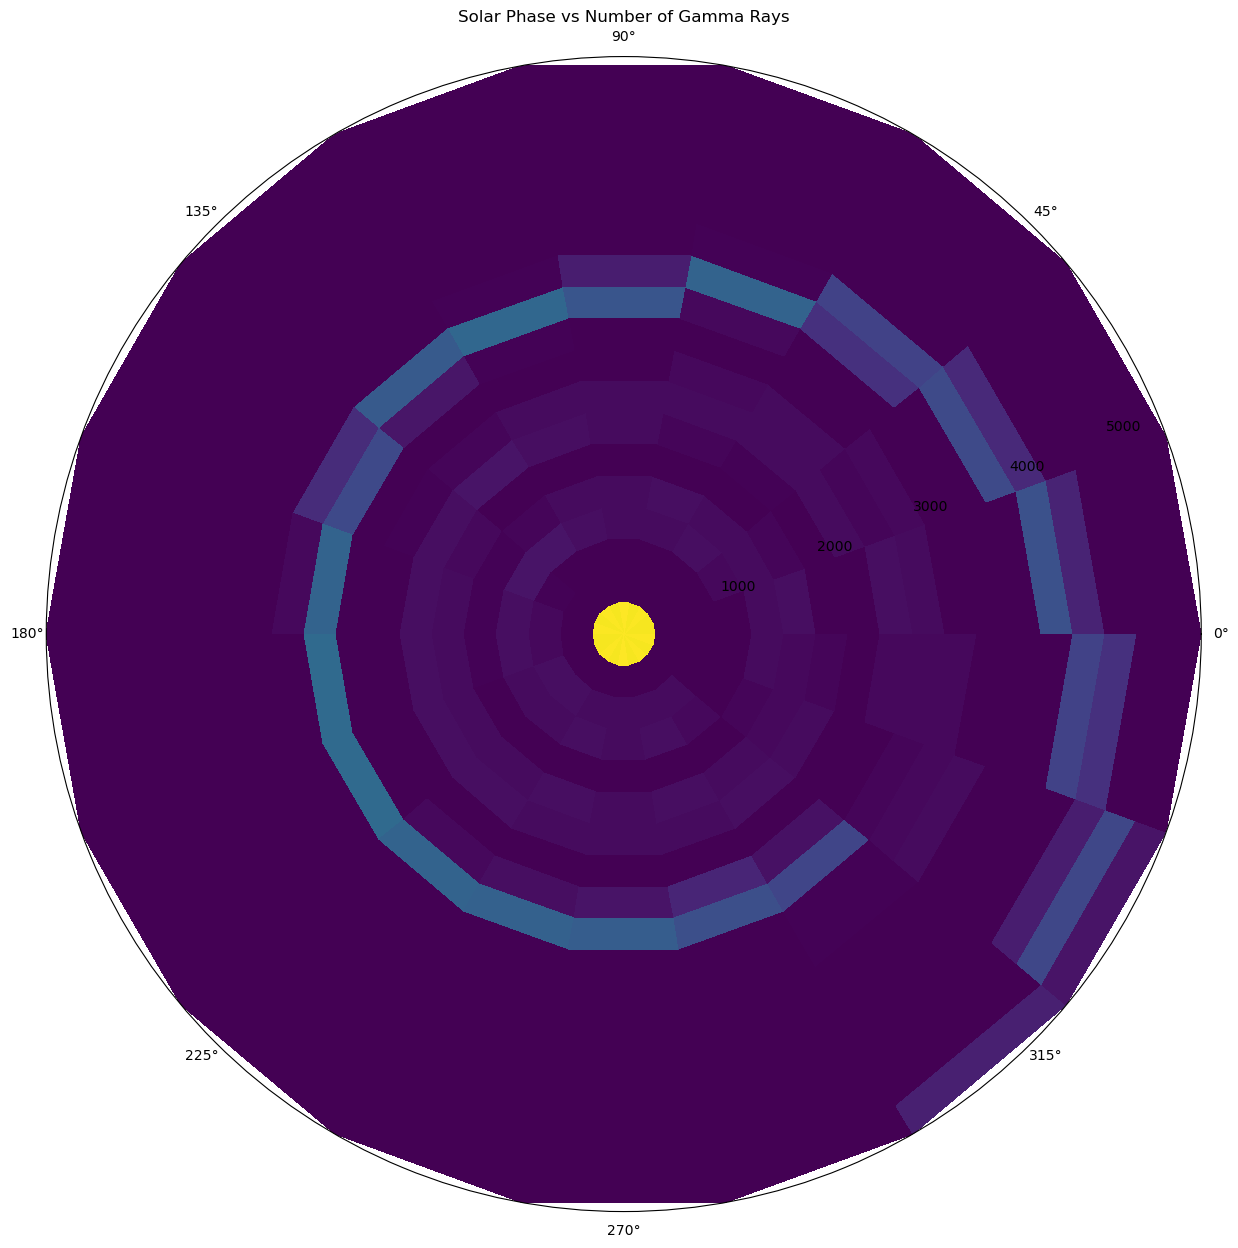

In [76]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
plt.title("Solar Phase vs Number of Gamma Rays")
plt.hist2d(np.linspace(0,2*np.pi,3600), counts, bins = 18)

plt.show()

Here we can see that the solar phase has little impact on the distribution of the number of gama rays that we see. We see 

In [79]:
means = [0]*54000
for i in range(54000):
    means[i] = df["count"][i::54000].mean()


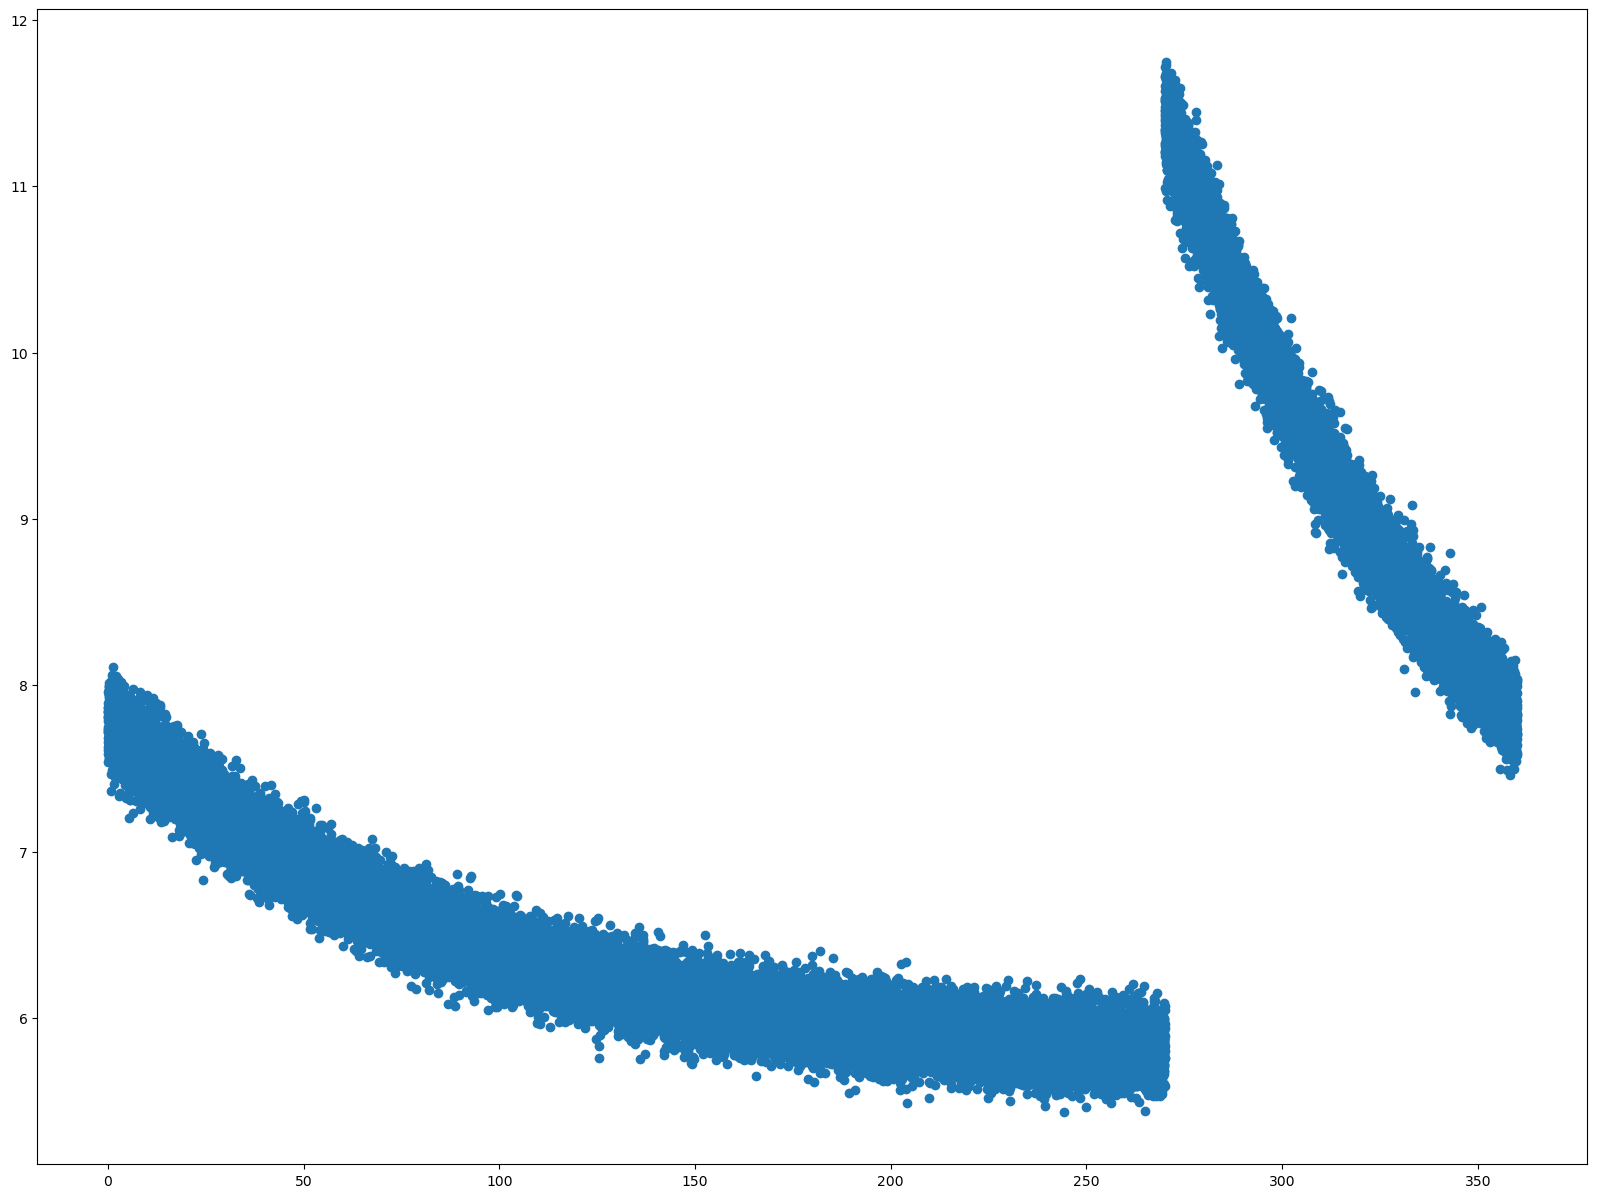

In [84]:
plt.scatter(x = np.linspace(0,360,54000),y = means)
plt.show()

In [106]:
rearanged_means = means[40500:] + means[:40500]

TypeError: plot got an unexpected keyword argument 'x'

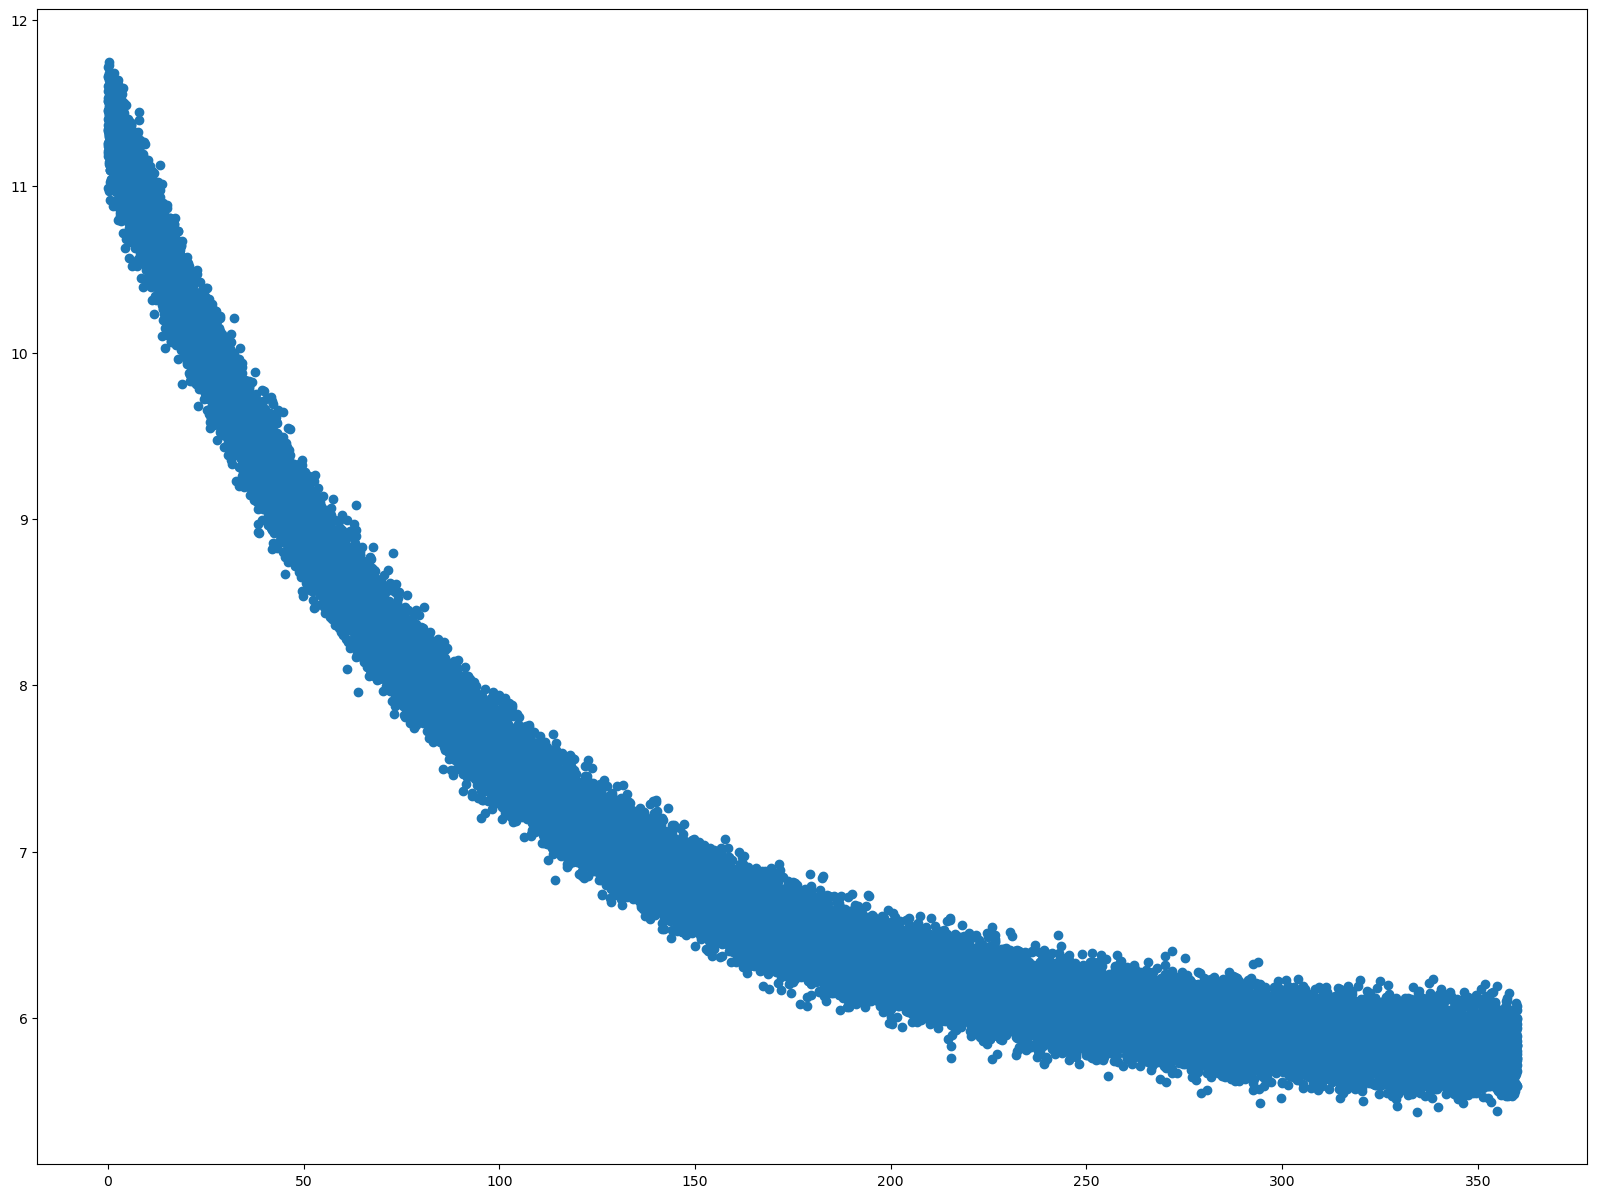

In [111]:
x = np.linspace(0,360,54000)
y = scipy.stats.expon.pdf(x)
plt.scatter(x=x,y = rearanged_means)
plt.plot(x = x, y = y )
plt.show()

In [54]:
counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4270,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3720,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3512,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3345,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3087,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2884,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2921,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,